# Inversion of field MT data from the Coompana Province, South Australia
## MT site KN_1
### Data source: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/112942

### Results report: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/112981  (Figure 5)

## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from scipy.sparse import diags

import cofi
import cofi_espresso
from cofi_espresso import Magnetotelluric1D

In [2]:
mt = Magnetotelluric1D()

#### 0.1 Load the data

In [3]:
file_name = '16-A_KN2.dat'

The data in the *16-A_KN2.dat*  file has been transformed from the original *16-A_KN2.edi*  file. 

The original file contains the information about the full impedance tensor $Z$ and its error. For the purpose of the 1D inversion presented here, we calculated beforehand the determinant of the complex impedance tensor, from which we then calculated the apparent resistivity, phase and their respective errors. 

In [4]:
# read and print the header
f = open('../data/%s'%(file_name))
header = f.readline()
print(header)

        freq(Hz)      rho(ohm.m)         err_rho      phase(deg)       err_phase



In [5]:
# load the data, transform the apparent resistivity and its error to log10
MTdata = np.loadtxt('../data/%s'%(file_name),skiprows=1)
MTdata = MTdata[::2,:]

freqs = MTdata[:,0]
rho_app = MTdata[:,1]
rho_app_err = MTdata[:,2]
phase = MTdata[:,3]
phase_err = MTdata[:,4]

dobs = np.r_[np.log10(rho_app), phase]

log10_drho_app = (1/np.log(10)) * (MTdata[:,2]/MTdata[:,1])


In [6]:
# add an error floor to the data: if the error if lower than the floor, then it is raised to the floor
# it prevents from including unrealistic small data error into the inversion

error_floor_rho = 0.05 # the error floor is set as a percentage of the apparent resistivity 
ef_rho_log = np.log10(1 + error_floor_rho) 
ef_phy = (100 * error_floor_rho) * 0.286    

err_rho_log = np.maximum(log10_drho_app, ef_rho_log)
err_phy = np.maximum(MTdata[:,4], ef_phy)

derr = np.r_[err_rho_log, err_phy]

#### 0.2 Set-up and plot the data

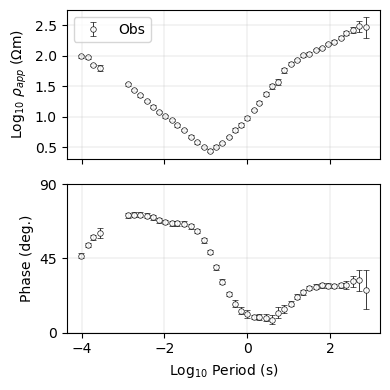

In [7]:
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [8]:
# the mesh contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model, mesh and data 

In [9]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)
mt.set_obs_data(dobs, derr, freqs)

## 1. Define the problem

The inversion consists in minimizing the following cost function:
$$\Phi=\Phi_d+{\lambda\Phi}_m$$

$\Phi_d$ is the data misfit term, defined as:
$$\Phi_d = ||W_d(d_{obs}-(F(m))||^2 = [d_{obs}-(F(m)]^T  W_d   [d_{obs}-(F(m)]$$

with $W_d$ being the inverse data covariance matrix, $d_{obs}$ is the observed data and $F(m)$ the responses of the model $m$.



$\Phi_m$ is the model norm term, defined as: 

$$\Phi_m=||L m||^2 = m^TL^TLm$$

In this inversion we minimize the model term using first derivatives, i.e. it minimizes the model roughness.  $\lambda$ is the regularization parameter, it defines the trade off between data misfit and model roughness. 

Following Brodie (2015) and Constable et al (1987) we define the regularization matrix $L$ as the first derivative operator $\partial$ normalized by the layers geometry vector $D$ (the resistivity gradient between adjacent layers is normalized by the distance between the center of layers). It is defined as:

$$L = D\circ\partial  $$

$L$ is a $N-1 \times N$ matrix, where $N$ is the number of model parameters $m$:

$$L=D\circ\partial= 
\frac{1}{(N -1)}
\begin{bmatrix}
\frac{\sqrt{s_2}}{d_{12}}\\
\frac{\sqrt{s_3}}{d_{23}}\\
\frac{\sqrt{s_4}}{d_{34}}\\
\cdots
\end{bmatrix}
\circ
\begin{bmatrix}
-1 & 1 & 0&0&&\cdots \\  
0& -1 & 1 &0&&\cdots \\ 
0& 0 & -1 &1&&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix} 
= \frac{1}{(N -1)} 
\begin{bmatrix}
\frac{-\sqrt{s_2}}{d_{12}} & \frac{\sqrt{s_2}}{d_{12}} & 0&0&&\cdots  \\  
0& \frac{-\sqrt{s_3}}{d_{23}} & \frac{\sqrt{s_3}}{d_{23}} &0&&\cdots \\ 
0& 0&\frac{-\sqrt{s_4}}{d_{34}} & \frac{\sqrt{s_4}}{d_{34}} &&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix}
$$

with $d_{ij}$ the distance between center of adjacent layers, and $s_k$ defined as $s_k=\frac{t_k}{\overline{t}}$ with $t$ beeing the layer thicknesses. See Brodie(2015) for details.

Following Key (2009) and Constable et al (1987), we can also define a penalty weights matrix $W_m$. The penalty weights matrix is a diagonal matrix applied to $L$. The weight $w_{ij}$ for the boundary beetween layer $i$ and $j$ defines the amount of smoothness constraint applied at that specific boundary. It is defined between 1 (smoothness applied) and 0 (no smoothness constraint) as each layer boundary. $W_m$ is a $N-1 \times N-1$ matrix defined as:

$$W_m = \begin{bmatrix}
w_{12} & 0 & 0 & 0&&\cdots \\  
0 & w_{23} & 0& 0&&\cdots \\ 
0 & 0 & w_{34}& 0&&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix}$$

$W_m$ can be used to specify at which depths the smoothness constraint should be relaxed, allowing a sharp boundary to devellop. 

Finally, the regularization matrix $L$ takes the form:

$$L = W_m D\circ\partial$$


#### References:

Brodie, R. C. (2015). User manual for Geoscience Australia’s airborne electromagnetic inversion software. Online: https://github.com/GeoscienceAustralia/ga-aem.git.

Constable, S. C., Parker, R. L., & Constable, C. G. (1987). Occam’s inversion: A practical algorithm for generating smooth models from electromagnetic sounding data. Geophysics, 52(3), 289-300.

Key, K. (2009). 1D inversion of multicomponent, multifrequency marine CSEM data: Methodology and synthetic studies for resolving thin resistive layers. Geophysics, 74(2), F9-F20.

In [10]:
# define regularization (following Constable 1987, Brodie 2015)
def reg_mt(depths, lambda_reg = 1, depth_normalization = True, penalty_index = None):
    # nL is the number of layers, equal to the number of model parameters
    nL = len(depths) + 1
    #layers thicknesses
    th = [depths[i] - depths[i-1] for i in range(nL-1)] 
    th[0] = depths[0]
    #thickness bottom half space (following Brodie (2015))
    th = np.array(np.append(th, (th[-1])**2 / (th[-2]))) / 1000 #(in km)
    #distance between center of adjacent layers
    d_layers_centers = [((th[i]+th[i+1])/2) for i in range(len(th)-1)]
    #define depth factor
    if depth_normalization:
        #mean layers thickness
        th_mean = np.mean(th)
        # define s_k
        sk = [th[i]/th_mean for i in range(len(th))]
        #define depth_factor
        depth_norm = (1/(nL-1)) * np.array([np.sqrt(sk[i])/d_layers_centers[i] for i in range(nL-1)])
    else:
        depth_norm = [1/d_layers_centers[i] for i in range(nL-1)]
    depth_norm = np.array(depth_norm).reshape((-1,1))
    #define first derivative matrix 
    delta=((diags([-1, 1], [0,1], shape=(nL-1, nL)).toarray())) 
    #define penalty weights matrix
    Wm = np.identity(nL-1) 
    if penalty_index is None:
        return lambda_reg * Wm @ delta * (depth_norm)
    else:
        Wm[penalty_index,penalty_index] = 0.1
        return lambda_reg * Wm @ delta * (depth_norm)


In [11]:
# get problem information from  espresso mt
model_size = len(mt.starting_model)         # number of model parameters
data_size = mt.data_size           # number of data points
start_logres = mt.starting_model
starting_depths = mt._dpstart

In [12]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(start_logres)

In [13]:
L = reg_mt(starting_depths, lambda_reg = 10, depth_normalization = True, penalty_index = None)

In [14]:
def objective_func(logres, reg, depths = starting_depths):
    dpred = mt.forward(logres, depths=depths)
    reg_smooth = logres.T @ reg.T @ reg @ logres
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    return  data_misfit + reg_smooth

In [15]:
mt_problem.set_objective(objective_func, args=[L,starting_depths])

In [16]:
#mt_problem.summary()

## 2. Define the inversion options

In [17]:
#mt_problem.suggest_tools();

In [18]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [19]:
#my_options.suggest_solver_params()

## 3. Start an inversion

In [20]:
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 1.4217090152485112
jac: [ 0.02771903  0.0565453   0.06239176  0.02715095  0.0216867   0.04333747
  0.02177516 -0.01492615 -0.00116569  0.03244023  0.00041109 -0.10242727
 -0.12587351 -0.12837842 -0.12114922 -0.1158494  -0.12911217 -0.12385959
 -0.06273844 -0.00796652  0.01723381  0.02369882  0.02052576  0.0142369
  0.00853762  0.00425375  0.00103086 -0.00149114 -0.00347085 -0.0049849
 -0.00612639 -0.0069853  -0.00761764 -0.00804175 -0.00825455 -0.00823963
 -0.00798381 -0.00748432 -0.0067653  -0.005885   -0.00491756 -0.0039432
 -0.00301417 -0.00214948 -0.00133094 -0.00052529  0.00030225  0.00117717
  0.00212521  0.00316143  0.00428828  0.00549401  0.00675069  0.00801785
  0.00925078  0.01040359  0.01143334  0.01229292  0.01292111  0.01325455
  0.01325884  0.01297995  0.01259153  0.01244769  0.01314899  0.0156495
  0.02123857  0.03045191  0.03967484  0.04120824  0.03404201  0.02467813
  0.01730056  0.01236073  0.00917

## 4. Plotting inversion results

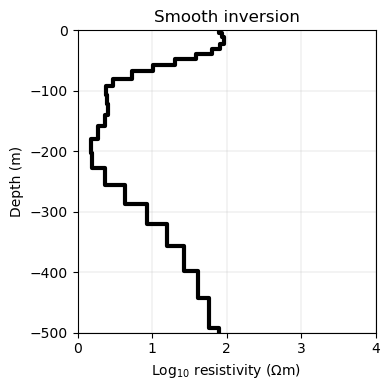

In [21]:
#fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)
#fig = mt.plot_model(mt.good_model, title='True model')
fig1 = mt.plot_model(inv_result.model, depths = mt._dpstart, max_depth = -500, title='Smooth inversion');            # inverted model

nRMSE = 0.935


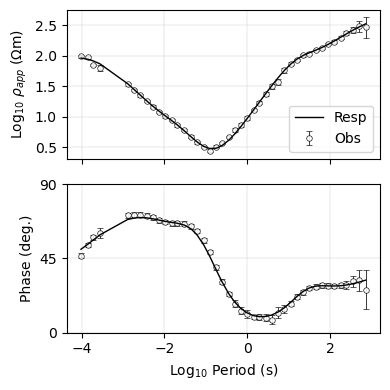

In [22]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm_inv = mt.inverse_covariance_matrix))
print('nRMSE = %.3f'%nRMSE)